In [3]:
import numpy as np
import seaborn as sns
import hypertools as hyp
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from itertools import combinations, permutations
from collections import defaultdict

%load_ext line_profiler
%matplotlib inline

In [4]:
#generate some fake data
N = 34 #number of events
D = 100 #number of dimensions
S = 17  #number of subjects
events_template = np.random.randn(N, D)

def get_subject_events(template, p_rec=0.5, var=0.1):
    recalled = np.random.rand(template.shape[0]) <= p_rec
    return template[recalled, :] + np.multiply(var, np.random.randn(np.sum(recalled), template.shape[1]))

def get_event_labels(template, data):
    corrs = cdist(template, data, 'correlation')
    labels = np.zeros(data.shape[0])
    for i in np.arange(data.shape[0]):
        labels[i] = np.where(corrs[:, i] == np.min(corrs[:, i]))[0][0] #when in doubt, prefer earliest match
    return list(labels)

subj_data = list(map(lambda x: get_subject_events(events_template), np.arange(S)))
labels = list(map(lambda x: get_event_labels(events_template, x), subj_data))

In [5]:
def get_event_centers(data, labels):
    if (len(data) == 0) or (len(data) != len(labels)):
        return None, None
    
    all_labels = []
    for x in labels:
        all_labels.extend(x)
    unique_labels = np.unique(np.array(all_labels)).astype(int)
    
    centers = np.zeros([int(np.max(unique_labels)+1), data[0].shape[1]])    
    n = np.zeros([int(np.max(unique_labels)+1), 1])
      
    for next_data, next_labels in zip(data, labels):
        for x in np.arange(len(next_labels)):
#             print(f'centers.shape = {centers.shape}; next_labels[x] = {next_labels[x]})')
#             print(f'centers[int(next_labels[x]), :].shape = {centers[int(next_labels[x]), :].shape}')
#             print(f'next_data[x, :].shape = {next_data[x, :].shape}')
            centers[int(next_labels[x]), :] += next_data[x, :]
            n[int(next_labels[x])] += 1
    return centers/n, unique_labels

In [6]:
def sq_dist_to_point(line, point):
    n = line[1] - line[0]
    pa = line[0] - point
    
    c = np.dot(n, pa)
    
    #closest point is a
    if c > 0:
        return np.dot(pa, pa)
    
    pb = point - line[1]
    
    #closest point is b
    if np.dot(n, pb) > 0:
        return np.dot(pb, pb)
    
    #closest point is between a and b
    e = pa - np.multiply(n, np.divide(c, np.dot(n, n)))
    return np.dot(e, e)
    

In [7]:
def get_hinge(data, labels, hinges=None):
    def min_sq_dist(point, hinges):
        min_dist = np.inf
        for i in np.arange(hinges.shape[0]-1):            
            next_dist = sq_dist_to_point([hinges[i, :], hinges[i+1, :]], point)
            if (next_dist < min_dist) and (next_dist != 0):
                min_dist = next_dist
        return min_dist
    
    def mse(data, hinges):
        sq_dist_sum = 0.
        for i in np.arange(data.shape[0]):
            sq_dist_sum += min_sq_dist(data[i, :], hinges)
        return np.divide(sq_dist_sum, data.shape[0])
    
    mean_events, all_labels = get_event_centers(data, labels)
    
    def hinge_mse(data, i):
        next_hinges = np.array([mean_events[0, :], mean_events[i, :], mean_events[-1, :]])
        next_labels = np.array([all_labels[0], all_labels[i], all_labels[-1]])
        next_mse = mse(data, next_hinges)
        return next_hinges, next_labels, next_mse    
    
    if hinges is None:
        best_hinges, best_labels, best_mse = hinge_mse(mean_events, 1)    
        for i in np.arange(2, mean_events.shape[0]):
            next_hinges, next_labels, next_mse = hinge_mse(mean_events, i)
            if next_mse < best_mse:
                best_hinges = next_hinges
                best_labels = next_labels
                best_mse = next_mse
    
        return best_hinges, best_labels, best_mse
    else:
        return np.sum(np.array(list(map(lambda d: mse(d, hinges), data))))
            

In [12]:
def get_k_hinges(all_data, all_labels, k):
    def add_endpoints(labels, inds):
        all_inds = np.zeros(len(inds)+2)
        all_inds[0] = labels[0]
        all_inds[-1] = labels[-1]
        all_inds[1:-1] = inds
        return all_inds.astype(np.int)
    
    def replace_hinge(data, hinges, from_ind, to_ind): #from ind is relative to *hinges* and to_ind is relative to *data*
        hinge_data = data[hinges, :]
        hinge_data[from_ind, :] = data[to_ind, :]
        return hinge_data
    
    def evenly_spaced_values(n, k):
        targets = np.round(np.linspace(0, n, k))
        for i in np.arange(k-1, 0, -1):
            if targets[i-1] == targets[i]:
                targets[i-1] -= 1
        targets[targets > n-1] = n-1
        targets[targets < 0] = 0
        unique_targets = np.unique(targets).astype(np.int)
        if len(unique_targets) != k:
            raise Exception
        return unique_targets.astype(np.int)
    
    data, labels = get_event_centers(all_data, all_labels)
    hinges = labels[evenly_spaced_values(len(labels), k+2).astype(np.int)]
    #hinges = add_endpoints(labels, np.sort(np.random.choice(np.arange(1, len(labels)-2), size=k, replace=False)))
    best_hinges = np.zeros_like(hinges, dtype=np.int)
    
    while not np.allclose(hinges, best_hinges):
        #for every triplet of hinges, optimize the middle point (and use it moving forward)
        best_hinges = np.copy(hinges).astype(np.int)
        for i in np.arange(len(hinges)-2):
            next_inds = np.arange(int(hinges[i])+1, int(hinges[i+2])) #possible positions for next hinge are bounded by neighbors      
            best_mse = np.inf
            best_ind = -1
            for j in next_inds:
                print(j)
                next_ind = next_inds[j]
                next_mse = get_hinge(all_data, all_labels, replace_hinge(data, best_hinges, i+1, next_ind))
                if next_mse < best_mse:
                    best_mse = next_mse
                    best_ind = j
            if best_ind != -1:
                hinges[i+1] = best_ind
    return data[hinges, :]

In [13]:
x1 = hyp.plot(subj_data, hue=labels, show=False, ndims=2);
hyp.plot([x1, get_k_hinges(subj_data, labels, 1)], ['r.:']*len(subj_data) + ['ko-'], ndims=2);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


IndexError: index 32 is out of bounds for axis 0 with size 32

Below this is random code (no longer relevant, but potentially useful for something)...

- 1.) divide data into two parts (training and test set)
- 2.) for k = 1…10, compute mse for each set of `k` optimal hinges using `mses[k] = get_hinge(test_data, test_labels, get_k_hinges(training_data, training_labels, k))` <-- `get_hinge` is somewhat strangely named; if you pass in pre-chosen hinges it just returns the MSE
- 3.) repeat steps 1 and 2 for many random assignments of training/test data (probably needs to run on cluster because it takes a little while to run)…although this might be able to be approximated with just a few runs (e.g. 10 or 20ish, which i think should run OK on a laptop)
- 4.) pick the k with the lowest average MSE
- 5.) now compute the final hinges using `get_k_hinges(all_data, all_labels, opt_k)`

In [225]:
video_events, subj_data = np.load('../data/events.npy')
labels = list(map(lambda x: list(x.astype(np.float)), np.load('../data/labels.npy')))

nperms = 1
nk = 10
mses = np.zeros((nperms, nk))
for n in range(nperms):
    training_data, test_data, training_labels, test_labels = train_test_split(subj_data, labels, test_size=.2)
    for k in range(nk):
        mses[n, k] = get_hinge(test_data, test_labels, get_k_hinges(training_data, training_labels, k+1))
        print(n,k)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


/opt/conda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


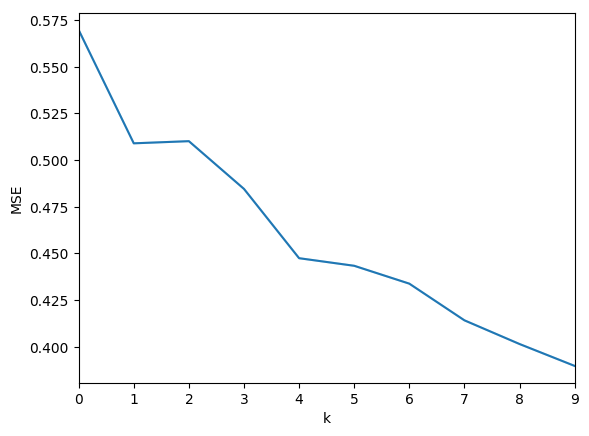

In [226]:
sns.reset_defaults()
sns.tsplot(mses, err_style='unit_traces')
plt.ylabel('MSE')
plt.xlabel('k')
plt.show()

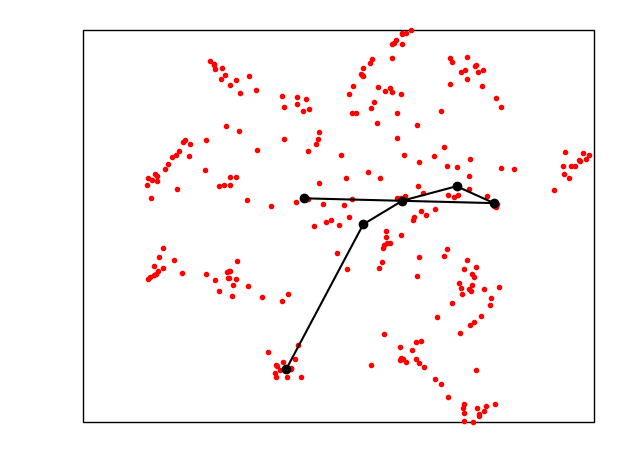

In [227]:
# x1 = hyp.plot(subj_data, hue=labels, show=False, ndims=2, reduce='UMAP');
hyp.plot(subj_data + [get_k_hinges(subj_data, labels, 4)], ['r.']*len(subj_data) + ['ko-'], ndims=2, reduce='UMAP');

In [4]:
def get_hinges(k, n):
    return [tuple([0]+list(c)+[n-1]) for c in combinations(range(1, n-1), k)]

def get_dists(segs, points):
    dist_dict = defaultdict()
    for p in points:
        dist_dict[tuple(p)] = defaultdict()
        for c in combinations(range(segs.shape[0]), 2):
                dist_dict[tuple(p)][c] = sq_dist_to_point([segs[c[0], :], segs[c[1], :]], p)
    return dist_dict

In [33]:
video_events, subj_data = np.load('../data/events.npy')
labels = list(map(lambda x: list(x.astype(np.float)), np.load('../data/labels.npy')))
subj_data = np.array(subj_data)

In [35]:
distdict = get_dists(video_events, np.vstack(subj_data))

In [3]:
%%lprun

res=[]
n=34
training_data, test_data = train_test_split(subj_data, test_size=.5)
for k in range(1, 11):
    stacked_data = np.vstack(training_data)
    best_dist = np.inf
    hingerator = combinations(range(n), k)
    done=False
    for i, h in enumerate(hingerator):
        while (np.diff([0]+list(h)+[n-1])<=2).any():
            try:
                h = next(hingerator)
                i+=1
            except StopIteration:
                done=True
                break
        if not done:
            h = [0]+list(h)+[n-1]
            dist = np.empty(len(stacked_data))
            for j, p in enumerate(stacked_data):
                dist[j] = min([distdict[tuple(p)][(h[i], h[i+1])] for i in range(len(h)-1)])
            next_dist = np.mean(dist)
            if next_dist < best_dist:
                best_dist = next_dist
                best_idx = i
                best_hinge = h
    
    stacked_data = np.vstack(test_data)
    dist = np.empty(len(stacked_data))
    for j, p in enumerate(stacked_data):
        dist[j] = min([distdict[tuple(p)][(best_hinge[i], best_hinge[i+1])] for i in range(len(best_hinge)-1)])
    test_error = np.mean(dist)
    
    r = {'k': k, 'training_error': best_dist, 'test_error': test_error, 'hinges': best_hinge}
    res.append(r)
    print(r)

ERROR:root:Cell magic `%%lprun` not found.


In [86]:
def hinge_generator(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    for indices in permutations(range(n), r):
        if sorted(indices) == list(indices) and ~(np.diff([0]+list(indices)+[n-1])<=2).any():
            yield tuple([0]+[pool[i] for i in indices]+[n-1])
            
def hinges_generator(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = range(r)
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        if ~(np.diff([0]+list(indices)+[n-1])<=2).any():
            yield tuple([0]+[pool[i] for i in indices]+[n-1])

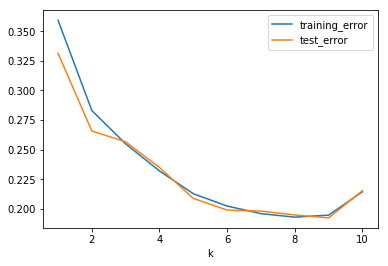

In [120]:
import pandas as pd
pd.DataFrame(res).set_index('k').filter(['training_error', 'test_error']).plot()

In [123]:
res2=[]
n=34
training_data, test_data = train_test_split(subj_data, test_size=.5, random_state=1)
for k in range(1, 11):
    stacked_data = np.vstack(training_data)
    best_dist = np.inf
    hingerator = combinations(range(n), k)
    done=False
    for i, h in enumerate(hingerator):
        while (np.diff([0]+list(h)+[n-1])<=2).any():
            try:
                h = next(hingerator)
                i+=1
            except StopIteration:
                done=True
                break
        if not done:
            h = [0]+list(h)+[n-1]
            dist = np.empty(len(stacked_data))
            for j, p in enumerate(stacked_data):
                dist[j] = min([distdict[tuple(p)][(h[i], h[i+1])] for i in range(len(h)-1)])
            next_dist = np.mean(dist)
            if next_dist < best_dist:
                best_dist = next_dist
                best_idx = i
                best_hinge = h
    
    stacked_data = np.vstack(test_data)
    dist = np.empty(len(stacked_data))
    for j, p in enumerate(stacked_data):
        dist[j] = min([distdict[tuple(p)][(best_hinge[i], best_hinge[i+1])] for i in range(len(best_hinge)-1)])
    test_error = np.mean(dist)
    
    r = {'k': k, 'training_error': best_dist, 'test_error': test_error, 'hinges': best_hinge}
    res2.append(r)
    print(r)

{'k': 1, 'training_error': 0.3566195529302386, 'test_error': 0.33097098722770524, 'hinges': [0, 13, 33]}
{'k': 2, 'training_error': 0.28127249895334866, 'test_error': 0.26562249255051795, 'hinges': [0, 13, 27, 33]}
{'k': 3, 'training_error': 0.25786971137142295, 'test_error': 0.24103392005972993, 'hinges': [0, 8, 13, 27, 33]}
{'k': 4, 'training_error': 0.23434988689631656, 'test_error': 0.2189699157004668, 'hinges': [0, 8, 13, 21, 27, 33]}
{'k': 5, 'training_error': 0.21139117196505178, 'test_error': 0.20986362230973502, 'hinges': [0, 8, 13, 19, 23, 27, 33]}
{'k': 6, 'training_error': 0.20098785702108746, 'test_error': 0.20009498495926864, 'hinges': [0, 4, 8, 13, 19, 23, 27, 33]}
{'k': 7, 'training_error': 0.19695368913843014, 'test_error': 0.1972919068558513, 'hinges': [0, 4, 8, 13, 19, 23, 27, 30, 33]}
{'k': 8, 'training_error': 0.19427060841349458, 'test_error': 0.19372506005894127, 'hinges': [0, 4, 8, 13, 16, 19, 23, 27, 30, 33]}
{'k': 9, 'training_error': 0.19247994327132126, 'tes

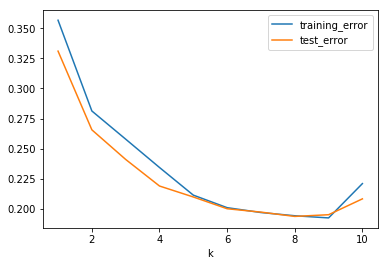

In [124]:
import pandas as pd
pd.DataFrame(res2).set_index('k').filter(['training_error', 'test_error']).plot()

In [126]:
res3=[]
n=34
training_data, test_data = train_test_split(subj_data, test_size=.5, random_state=2)
for k in range(1, 11):
    stacked_data = np.vstack(training_data)
    best_dist = np.inf
    hingerator = combinations(range(n), k)
    done=False
    for i, h in enumerate(hingerator):
        while (np.diff([0]+list(h)+[n-1])<=2).any():
            try:
                h = next(hingerator)
                i+=1
            except StopIteration:
                done=True
                break
        if not done:
            h = [0]+list(h)+[n-1]
            dist = np.empty(len(stacked_data))
            for j, p in enumerate(stacked_data):
                dist[j] = min([distdict[tuple(p)][(h[i], h[i+1])] for i in range(len(h)-1)])
            next_dist = np.mean(dist)
            if next_dist < best_dist:
                best_dist = next_dist
                best_idx = i
                best_hinge = h
    
    stacked_data = np.vstack(test_data)
    dist = np.empty(len(stacked_data))
    for j, p in enumerate(stacked_data):
        dist[j] = min([distdict[tuple(p)][(best_hinge[i], best_hinge[i+1])] for i in range(len(best_hinge)-1)])
    test_error = np.mean(dist)
    
    r = {'k': k, 'training_error': best_dist, 'test_error': test_error, 'hinges': best_hinge}
    res3.append(r)
    print(r)

{'k': 1, 'training_error': 0.34857669089984805, 'test_error': 0.34044901631695573, 'hinges': [0, 13, 33]}
{'k': 2, 'training_error': 0.2816002864993965, 'test_error': 0.2844603418608407, 'hinges': [0, 4, 13, 33]}
{'k': 3, 'training_error': 0.25450288887076605, 'test_error': 0.2642012866189022, 'hinges': [0, 10, 13, 23, 33]}
{'k': 4, 'training_error': 0.23146778717465408, 'test_error': 0.23635193279388148, 'hinges': [0, 10, 13, 23, 27, 33]}
{'k': 5, 'training_error': 0.21331506279978293, 'test_error': 0.21507692416323962, 'hinges': [0, 10, 13, 19, 23, 27, 33]}
{'k': 6, 'training_error': 0.20025240085078208, 'test_error': 0.20771713232918793, 'hinges': [0, 4, 10, 13, 19, 23, 27, 33]}
{'k': 7, 'training_error': 0.1962608807068142, 'test_error': 0.19806263318662318, 'hinges': [0, 4, 10, 13, 17, 20, 23, 27, 33]}
{'k': 8, 'training_error': 0.19245148352457606, 'test_error': 0.192340097614671, 'hinges': [0, 4, 10, 13, 17, 20, 23, 26, 29, 33]}
{'k': 9, 'training_error': 0.18985443075750133, 't

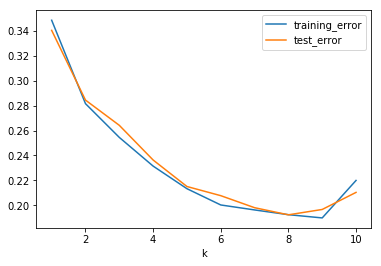

In [127]:
import pandas as pd
pd.DataFrame(res3).set_index('k').filter(['training_error', 'test_error']).plot()